In [1]:
# example of loading the fashion mnist dataset
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
# load dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


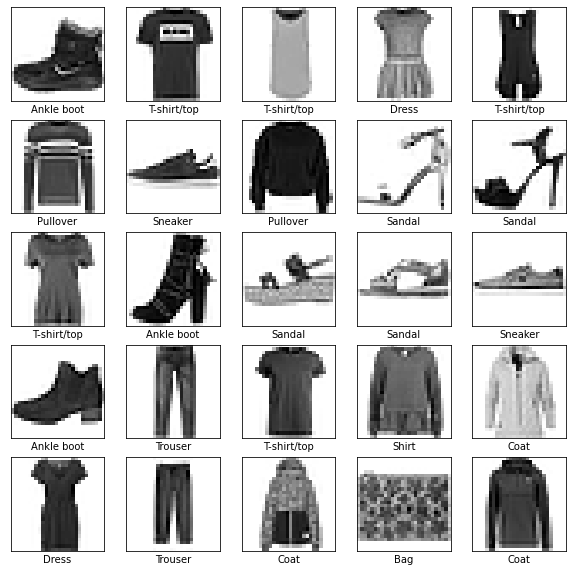

In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# plot first few images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
# show the figure
plt.show()

In [3]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [4]:
# Normalize the data
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [5]:
import tensorflow as tf

num_classes = 10


# One hot encode the labels (neural nets only like numbers)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [6]:
item_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover',
              3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
              7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

In [7]:
# WandB – Install the W&B library
#!pip install wandb -q
#!pip install opencv-python
import wandb
from wandb.keras import WandbCallback

wandb: WARNING Keras version 2.3.0 is not fully supported. Required keras >= 2.4.0


In [8]:
# Initilize a new wandb run
wandb.init(entity="yhenig", project="project")

# Default values for hyper-parameters
config = wandb.config # Config is a variable that holds and saves hyperparameters and inputs
config.learning_rate = 0.01
config.epochs = 35
config.img_width=28
config.img_height=28
config.num_classes = num_classes
config.batch_size = 128
config.validation_size = 5000
config.weight_decay = 0.0005
config.activation = 'relu'
config.optimizer = 'nadam'
config.seed = 42

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/ubuntu/.netrc


In [18]:
# define cnn model
def define_model(lr=0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # define the optimizer
    optimizer = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    # compile model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def augmentation(X_data):
    # Data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_data)

In [20]:
def benchmark(lr=0.01):
    %%wandb
    # define model with lr=0.01
    model = define_model(lr)

    # data augmentation
    augmentation(X_train)

    # fit model
    history = model.fit(X_train, y_train,
                        epochs=config.epochs, batch_size=config.batch_size,
                        validation_data=(X_test, y_test),
                        verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                                  WandbCallback(data_type="image", validation_data=(X_test, y_test), labels=item_names)])
    # evaluate model
    _, acc = model.evaluate(X_test, y_test, verbose=0)
    
    return history, acc

In [11]:
benchmark(0.01)

first run with 9 epochs

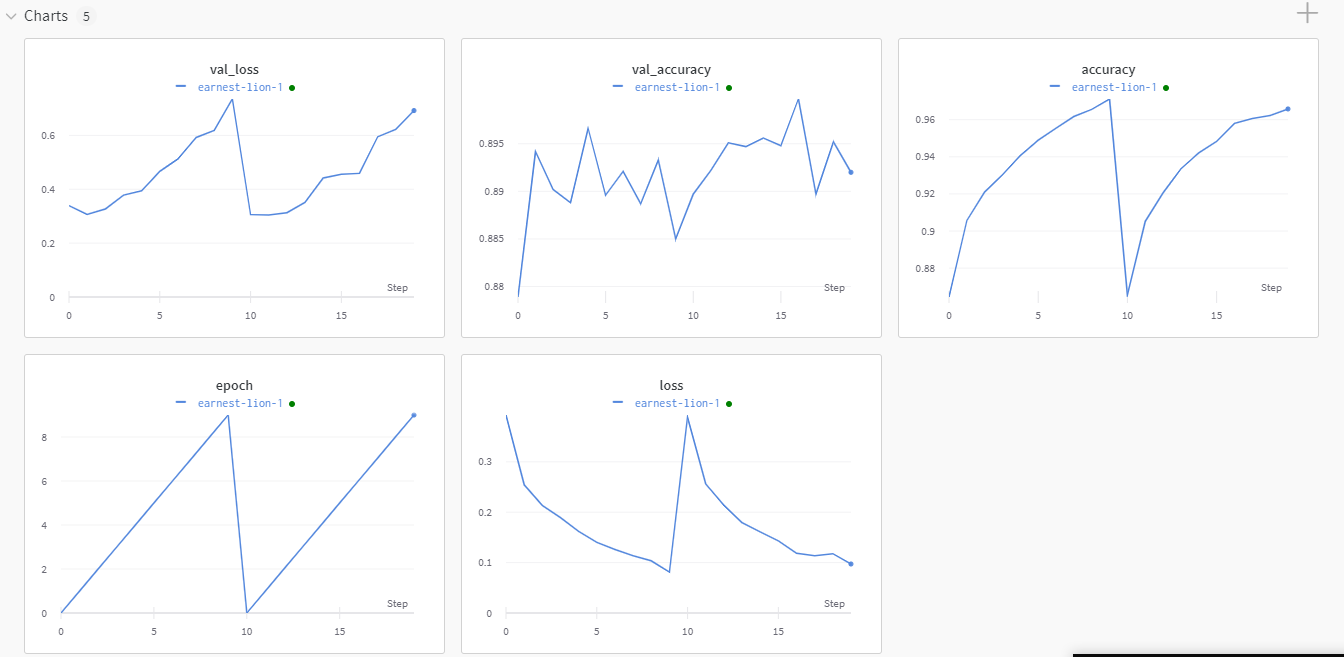

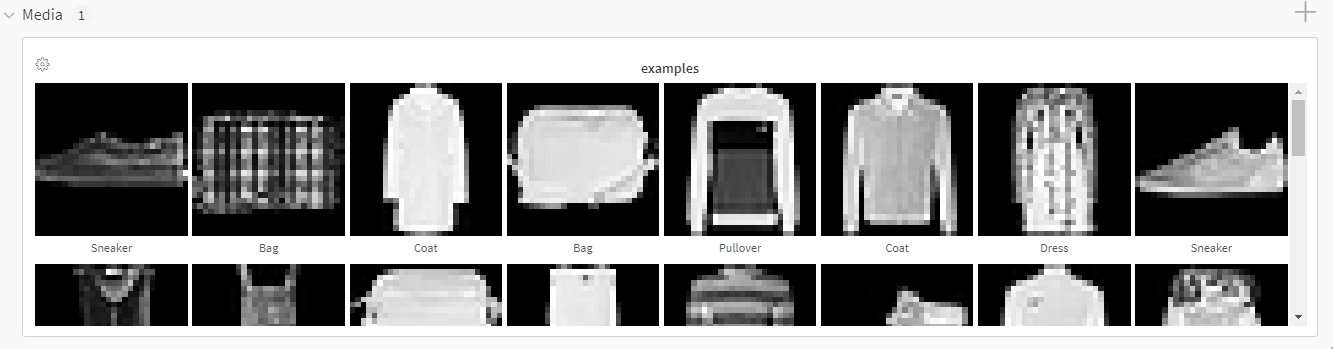

In [12]:
print(f'Acc: {(acc * 100.0):.3f}%')

Acc: 90.610%


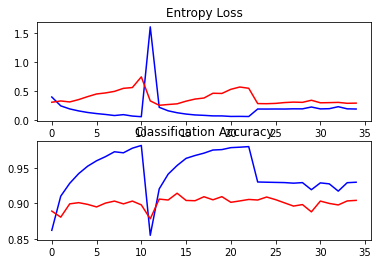

In [14]:
# plot loss
plt.subplot(211)
plt.title('Entropy Loss')
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='b', label='train')
plt.plot(history.history['val_accuracy'], color='r', label='test')

plt.show()

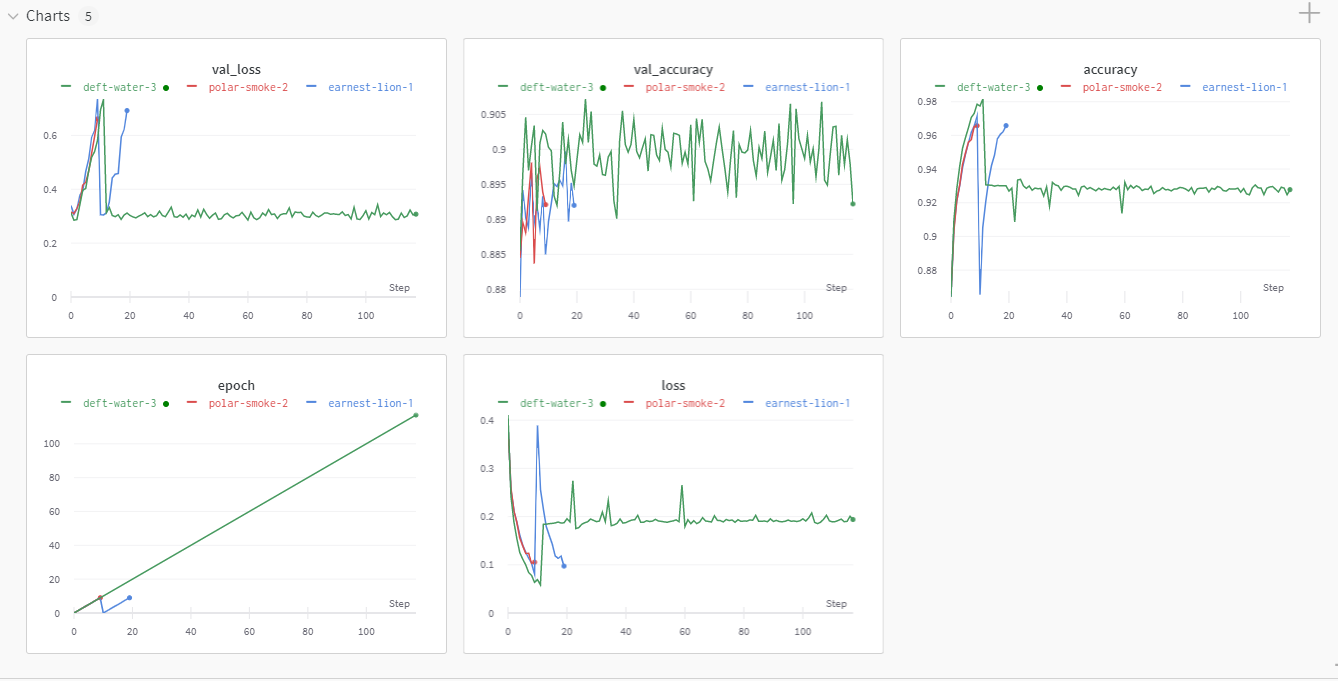

In [22]:
history, acc = benchmark(0.001)

In [23]:
print(f'Acc: {(acc * 100.0):.3f}%')

Acc: 91.880%


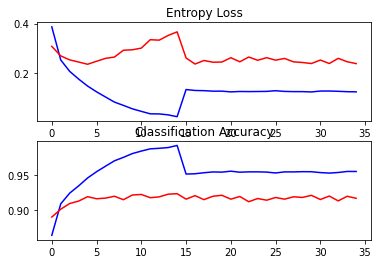

In [24]:
# plot loss
plt.subplot(211)
plt.title('Entropy Loss')
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='b', label='train')
plt.plot(history.history['val_accuracy'], color='r', label='test')

plt.show()

In [25]:
history, acc = benchmark(0.0001)

In [26]:
print(f'Acc: {(acc * 100.0):.3f}%')

Acc: 92.200%


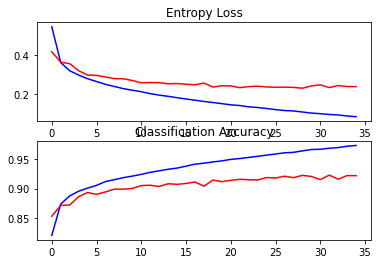

In [27]:
# plot loss
plt.subplot(211)
plt.title('Entropy Loss')
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='b', label='train')
plt.plot(history.history['val_accuracy'], color='r', label='test')

plt.show()

In [15]:
model.save('model1.h5')